In [1]:
from cobra.io import read_sbml_model
from os.path import dirname, join, pardir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint

## Create Black Box Model from GEM 

In [2]:
data_dir = "/Users/phivri/Documents/GitHub/Biosustain/MoGeoModel"
model = read_sbml_model(join(data_dir,'Models/p-thermo_acetone_anaerobic.xml'))

In [3]:
medium = model.medium
medium["EX_o2_e"] = 1000.0
medium["EX_ac_e"] = 10.0
medium["EX_sucr_e"] = 0.0
medium["EX_glc__D_e"] = 0.0
model.medium = medium

model.medium

{'EX_cl_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_ac_e': 10.0,
 'EX_pi_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_btn_e': 1.0,
 'EX_thmpp_e': 1.0,
 'EX_sprm_e': 1.0,
 'EX_spmd_e': 1.0,
 'EX_adocbl_e': 1.0,
 'EX_10fthf_e': 1.0,
 'EX_fe3_e': 1.0,
 'EX_pheme_e': 1.0}

In [4]:
solution = model.optimize()
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
10fthf_e,EX_10fthf_e,4.711E-05,20,0.00%
ac_e,EX_ac_e,10,2,99.95%
adocbl_e,EX_adocbl_e,2.626E-05,72,0.01%
btn_e,EX_btn_e,2.356E-07,10,0.00%
ca2_e,EX_ca2_e,0.000371,0,0.00%
fe2_e,EX_fe2_e,2.626E-05,0,0.00%
fe3_e,EX_fe3_e,0.004005,0,0.00%
h_e,EX_h_e,9.046,0,0.00%
k_e,EX_k_e,0.08341,0,0.00%
mg2_e,EX_mg2_e,0.01154,0,0.00%


Lisowska, Beata. Genomic analysis and metabolic modelling of Geobacillus thermoglucosidasius NCIMB 11955. Diss. University of Bath, 2016.

growth rate around 0.3

In [5]:
X = solution.fluxes.EX_Biomass_e
Actt = solution.fluxes.EX_ac_e
CO2 = solution.fluxes.EX_co2_e
O2 = solution.fluxes.EX_o2_e

X, Actt, CO2, O2

(0.1319130809690115, -10.0, 15.262528289111026, -15.037420958165503)

In [6]:
Ks_O2 = 0.022 # [mM] from glucose in E.coli 10.1007/s00253-006-0717-7

#Ki_actt = 16.7 # [mM] Inhibition constant for acetate, measured in Daniel's project around 1g/L, 1/60*1000

µ_max = 0.3 # [/h]

In [7]:
def µ(C_O2):
    return µ_max * C_O2/(0.022+C_O2)

def q_CO2(C_O2):
    return µ(C_O2)/(X/CO2)

def q_O2(C_O2):
    return µ(C_O2)/(X/O2)

def q_actt(C_O2):
    return µ(C_O2)/(X/Actt)

## Run simulation 

In [8]:
T = 333.15 #Temperature in Celsius
R = 8.314 # [m^3*Pa/K/mol]
t_rn = 100.0 # Run time [h]

#Reactor 2
F2_L = 100 #Fluid inflow rate with C-source supplement [m^3/h]
F2_G = 1 * 10**2 #gas inflow rate [m^3/h]
r2 = 1 # radius of the reactor [m]
h2 = 5 # height of the reactor [m]

A2 = math.pi * r2**2 #reactor cross-sectional area [m^2]
V2_L = A2 * h2 * 2/3 #reactor volume, assuming it is 2/3 filled [m^3]
v2_gas = F2_G/A2/3600 #average gas velocity [m/s]
Gas_holdup2 = 0.6*(v2_gas)**0.7 #from Stephanie's paper
V2_G = V2_L*Gas_holdup2

p2_t = 101325 # pressure at the top of the reactor [Pa]
p2_b = p2_t + h2 * 1000 * 9.81 # pressure at the bottom of the reactor [Pa]
p2_m = (p2_b-p2_t)/math.log(p2_b/p2_t) # logarithmic mean pressure [Pa]

c_Actt_in = 10

print(f"Reactor 2 is a CSTR of {round(A2 * h2,2)}m^3, of which the broth occupies {round(V2_L,2)}m^3, and the gas {round(V2_G,2)}m^3.")

print(f"The mean logarithmic pressure in the tank is {round(p2_m,2)}[Pa]")


Reactor 2 is a CSTR of 15.71m^3, of which the broth occupies 10.47m^3, and the gas 0.23m^3.
The mean logarithmic pressure in the tank is 124240.44[Pa]


In [9]:
#mol fraction of incoming gas
y2_co = 0.0 #[mol/mol]
y2_co2 = 0.0 #[mol/mol]
y2_h2 = 0.0 #[mol/mol]
y2_o2 = 0.2 #[mol/mol]
y2_n2 = 0.8 #[mol/mol]

cG2_CO2_in = y2_co2 * p2_m/(R*T)
cG2_CO_in = y2_co * p2_m/(R*T)
cG2_H2_in = y2_h2 * p2_m/(R*T)
cG2_O2_in = y2_o2 * p2_m/(R*T)
cG2_N2_in = y2_n2 * p2_m/(R*T)
cG2_Actn_in = 0.0

cG2_Gas_0 = cG2_CO2_in+cG2_CO_in+cG2_H2_in+cG2_O2_in+cG2_N2_in

In [10]:
# Constants:
# Diffusivity coefficient:
# E.L. Cussler, Diffusion - Mass Transfer in Fluid Systems, 2nd edition - Table 5.2-1
D0_CO = 2.03*10**(-5) #[cm2/s]
D0_CO2 = 1.92*10**(-5) #[cm2/s]
D0_H2 = 4.50*10**(-5) #[cm2/s]
D0_O2 = 2.10*10**(-5) #[cm2/s]
D0_N2 = 1.88*10**(-5) #[cm2/s]

# NIST Chemistry WebBook: https://webbook.nist.gov
theta = 1.022 # temperature correction factor
#Henry's law constant for solubility in water at 298.15 K
H0_CO = 0.00099 # mol/kg*bar]
H0_CO2 = 0.035 # [mol/kg*bar]
H0_H2 = 0.00078 # [mol/kg*bar]
H0_O2 = 0.0013 # [mol/kg*bar]
H0_N2 = 0.0006 # [mol/kg*bar]
#temepratute correction factor k 
k_CO = 1300 # [K]
k_CO2 = 2400 # [K]
k_H2 = 500 # [K]
k_O2 = 1500 # [K]
k_N2 = 1300 # [K]
#Temperature-corrected Henry’s law constant, HT:
HT_CO2 = H0_CO2 * math.e**(k_CO2*(1/T-1/298.15)) * 10**3 * 10**(-5) #[mol/m^3*Pa]
HT_CO = H0_CO * math.e**(k_CO*(1/T-1/298.15)) * 10**3 * 10**(-5) #[mol/m^3*Pa]
HT_H2 = H0_H2 * math.e**(k_H2*(1/T-1/298.15)) * 10**3 * 10**(-5) #[mol/m^3*Pa]
HT_O2 = H0_O2 * math.e**(k_O2*(1/T-1/298.15)) * 10**3 * 10**(-5) #[mol/m^3*Pa]
HT_N2 = H0_N2 * math.e**(k_N2*(1/T-1/298.15)) * 10**3 * 10**(-5) #[mol/m^3*Pa]

In [11]:
def R_O2(c_O2, cG_O2,cG_CO2,cG_N2):
    cG_Gas = cG_O2 + cG_CO2 + cG_N2
    KLa_O2 = 3.5 * v2_gas * theta**(T-293.15) * 3600 #[1/s]
    return KLa_O2*(HT_O2 * cG_O2/(cG_Gas) * p2_m * cG_Gas/cG2_Gas_0 - c_O2)

def R_CO2(c_CO2, cG_O2,cG_CO2,cG_N2):
    cG_Gas = cG_O2 + cG_CO2 + cG_N2
    KLa_CO2 = 3.5 * (D0_CO2/D0_O2)**0.5 * v2_gas * theta**(T-293.15) * 3600 #[1/s]
    return KLa_CO2*(HT_CO2 * cG_O2/(cG_Gas) * p2_m * cG_Gas/cG2_Gas_0 - c_CO2)

In [12]:
cG_N2 = 0
def model(z,t):
    c_X = max(0,z[0])
    c_Actt = max(0,z[1])
    c_O2 = max(0,z[2])
    c_CO2 = max(0,z[3])
    cG_O2 = max(0,z[4])
    cG_CO2 = max(0,z[5])

    dXdt    = µ(c_O2) * c_X
    dActtdt = q_actt(c_O2) * c_X + (c_Actt_in - c_Actt) * F2_L
    dO2dt   = q_O2(c_O2) * c_X + c_Actt_in + R_O2(c_O2, cG_O2,cG_CO2,cG_N2)
    dCO2dt  = q_CO2(c_O2) * c_X + R_CO2(c_CO2, cG_O2,cG_CO2,cG_N2)
    dO2Gdt  = F2_G/V2_G * (cG2_O2_in-cG_O2) - R_O2(c_O2, cG_O2,cG_CO2,cG_N2) * V2_L/V2_G
    dCO2Gdt = F2_G/V2_G * (cG2_CO2_in-cG_CO2) - R_CO2(c_CO2, cG_O2,cG_CO2,cG_N2) * V2_L/V2_G
    
    return [dXdt,dActtdt,dO2dt,dCO2dt,dO2Gdt,dCO2Gdt]

z0=[0.1,1,1,0,1,1]

#step function
t_rt = 15
t = np.linspace(0,t_rt,1000)

#solve ODE
z = odeint(model,z0,t)

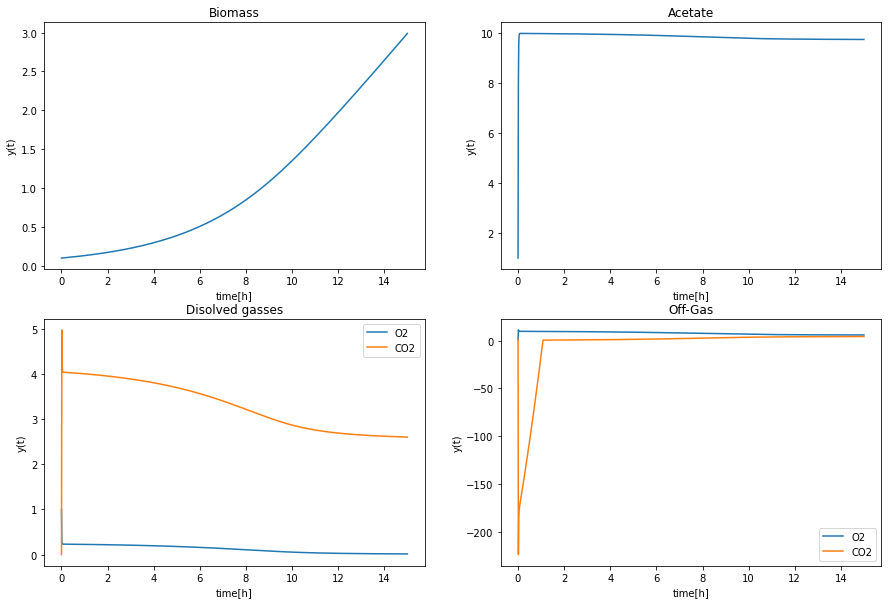

In [13]:
# plot results
fig = plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title("Biomass")
plt.plot(t,z[:,0])
plt.xlabel('time[h]')
plt.ylabel('y(t)')

plt.subplot(2,2,2)
plt.title("Acetate")
plt.plot(t,z[:,1])
plt.xlabel('time[h]')
plt.ylabel('y(t)')

plt.subplot(2,2,3)
plt.title("Disolved gasses")
plt.plot(t,z[:,2])
plt.plot(t,z[:,3])
plt.legend(['O2',"CO2"])
plt.xlabel('time[h]')
plt.ylabel('y(t)')

plt.subplot(2,2,4)
plt.title("Off-Gas")
plt.plot(t,z[:,4])
plt.plot(t,z[:,5])
plt.legend(['O2',"CO2"])
plt.xlabel('time[h]')
plt.ylabel('y(t)')

plt.show()

## Plot Oxygen consumption by growth rate

NGAM: 3.141 mmolATP/gDW/h, in ATPM reaction

GAM: 152.3 mmolATP/gDW, in biomass pseudoreaction

In [14]:
model = read_sbml_model(join(data_dir,'Models/p-thermo_acetone_anaerobic.xml'))
model.reactions.ATPM

Reaction identifier,ATPM
Name,ATP phosphohydrolase
Memory address,0x07fd13a018fd0
Stoichiometry,atp_c + h2o_c --> adp_c + h_c + pi_c ATP + Water --> ADP + H+ + Orthophosphate
GPR,RTMO00197 or RTMO00196 or RTMO00193 or RTMO00194 or RTMO04075 or RTMO00373 or RTMO03395 or...
Lower bound,3.141
Upper bound,1000.0


In [15]:
model.reactions.biomass

Reaction identifier,biomass
Name,biomass
Memory address,0x07fd1389e5fd0
Stoichiometry,0.000357142857142857 10fthf_c + 0.000249107142857144 accoa_c + 0.000199107142857143 adocbl_c + 0.514187446428571 ala__L_c + 0.000199107142857143 amet_c + 0.119274155357143 amp_c + 0.183080357142857... 0.000357142857142857 10-Formyltetrahydrofolate + 0.000249107142857144 Acetyl-CoA + 0.000199107142857143 Cobamide coenzyme + 0.514187446428571 L-Alanine + 0.000199107142857143 S-Adenosyl-L-...
GPR,RTMO05969
Lower bound,0.0
Upper bound,1000.0


In [16]:
medium = model.medium
medium["EX_glc__D_e"] = 0
medium["EX_o2_e"] = 100.0
model.medium = medium

model.optimize()
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
10fthf_e,EX_10fthf_e,0.0003414,20,0.01%
ac_e,EX_ac_e,67.98,2,99.95%
adocbl_e,EX_adocbl_e,0.0001903,72,0.01%
btn_e,EX_btn_e,1.707E-06,10,0.00%
ca2_e,EX_ca2_e,0.002689,0,0.00%
fe2_e,EX_fe2_e,0.0001903,0,0.00%
fe3_e,EX_fe3_e,0.02902,0,0.00%
h_e,EX_h_e,61.07,0,0.00%
k_e,EX_k_e,0.6044,0,0.00%
mg2_e,EX_mg2_e,0.08364,0,0.00%


/Users/phivri/opt/anaconda3/envs/cobrapy/lib/python3.6/site-packages/cobra/core/metabolite.py:104: UserWarning: 38.14 is not an integer (in formula C38.14H75.28O10P)
  % (count, self.formula)
/Users/phivri/opt/anaconda3/envs/cobrapy/lib/python3.6/site-packages/cobra/core/metabolite.py:104: UserWarning: 75.28 is not an integer (in formula C38.14H75.28O10P)
  % (count, self.formula)
/Users/phivri/opt/anaconda3/envs/cobrapy/lib/python3.6/site-packages/cobra/core/metabolite.py:104: UserWarning: 37.14 is not an integer (in formula C37.14H74.28NO8P)
  % (count, self.formula)
/Users/phivri/opt/anaconda3/envs/cobrapy/lib/python3.6/site-packages/cobra/core/metabolite.py:104: UserWarning: 74.28 is not an integer (in formula C37.14H74.28NO8P)
  % (count, self.formula)
/Users/phivri/opt/anaconda3/envs/cobrapy/lib/python3.6/site-packages/cobra/core/metabolite.py:104: UserWarning: 73.28 is not an integer (in formula C73.28H142.56O17P2)
  % (count, self.formula)
/Users/phivri/opt/anaconda3/envs/cobra

(0.0, 0.3, 0.0, 40.0)

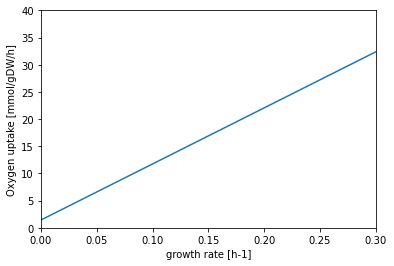

In [17]:
import cobra.test
from cobra.flux_analysis import production_envelope

prod_env = production_envelope(model, ["EX_o2_e"], objective="biomass", carbon_sources="EX_ac_e")

plt.plot(prod_env.flux_maximum,-prod_env.EX_o2_e)
plt.xlabel('growth rate [h-1]')
plt.ylabel('Oxygen uptake [mmol/gDW/h]')
plt.axis([0, 0.3, 0, 40])